In [1]:
import sys
import importlib
import warnings
from pathlib import Path
from datetime import datetime

# Add project root to path (works on any machine)
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D

from scipy.interpolate import griddata, UnivariateSpline
from scipy.ndimage import gaussian_filter
from scipy.signal import savgol_filter

from pricing.black_scholes import black_scholes
from pricing.greeks import compute_greeks
from data.fetch_option_chain import fetch_option_chain, fetch_multi_expiry_chains
from data.cleaning import clean_option_data
from vol_surface.iv_surface import (
    compute_implied_vols, add_moneyness_columns, extract_smile_at_expiry,
    compute_atm_vol, build_iv_surface
)
from vol_surface.smile_fitting import (
    fit_smile_spline, svi_total_variance, fit_svi_smile, compare_smile_fits
)

warnings.filterwarnings('ignore')

In [2]:
ticker = 'SPY'
target_days = [30, 60, 90, 180, 270, 365, 545, 730]  # Up to 2 years
chains_raw = fetch_multi_expiry_chains(ticker=ticker, target_expirations=target_days, mode='cache_or_live')

print(f"\nFetched {len(chains_raw)} expirations:")
for exp_date, df in chains_raw.items():
    days_to_exp = (pd.to_datetime(exp_date) - pd.to_datetime('2026-02-09')).days
    print(f"  {exp_date} ({days_to_exp}d): {len(df)} strikes, spot=${df['spot'].iloc[0]:.2f}")

[CACHE] Loaded: SPY 2026-03-13 from /Users/kousakaishou/Equity_Derivatives_Project/data/raw/SPY_options_2026-03-13.csv
[CACHE] Loaded: SPY 2026-04-17 from /Users/kousakaishou/Equity_Derivatives_Project/data/raw/SPY_options_2026-04-17.csv
[CACHE] Loaded: SPY 2026-05-15 from /Users/kousakaishou/Equity_Derivatives_Project/data/raw/SPY_options_2026-05-15.csv
[CACHE] Loaded: SPY 2026-07-31 from /Users/kousakaishou/Equity_Derivatives_Project/data/raw/SPY_options_2026-07-31.csv
[CACHE] Loaded: SPY 2026-09-30 from /Users/kousakaishou/Equity_Derivatives_Project/data/raw/SPY_options_2026-09-30.csv
[CACHE] Loaded: SPY 2027-01-15 from /Users/kousakaishou/Equity_Derivatives_Project/data/raw/SPY_options_2027-01-15.csv
[CACHE] Loaded: SPY 2027-06-17 from /Users/kousakaishou/Equity_Derivatives_Project/data/raw/SPY_options_2027-06-17.csv
[CACHE] Loaded: SPY 2028-01-21 from /Users/kousakaishou/Equity_Derivatives_Project/data/raw/SPY_options_2028-01-21.csv

Fetched 8 expirations:
  2026-03-13 (32d): 80 s

In [3]:
# Step 1: Clean and compute IVs for ALL expirations
all_chains_with_iv = {}
all_market_smiles = {}

for exp_date, raw_df in chains_raw.items():
    # Clean
    chain_clean = clean_option_data(raw_df)
    
    # Compute IVs
    chain_with_iv = compute_implied_vols(chain_clean, r=0.05)
    chain_valid = chain_with_iv.dropna(subset=['iv_call', 'iv_put'])
    
    # Add moneyness columns
    chain_enriched = add_moneyness_columns(chain_valid)
    
    # Extract market smile (OTM stitched)
    market_smile = extract_smile_at_expiry(chain_enriched)
    
    all_chains_with_iv[exp_date] = chain_enriched
    all_market_smiles[exp_date] = market_smile
    
    print(f"{exp_date}: {len(chain_valid)} valid strikes, {len(market_smile)} in smile")

print("\n✓ All expirations processed")

2026-03-13: 61 valid strikes, 62 in smile
2026-04-17: 85 valid strikes, 86 in smile
2026-05-15: 76 valid strikes, 77 in smile
2026-07-31: 72 valid strikes, 73 in smile
2026-09-30: 104 valid strikes, 105 in smile
2027-01-15: 62 valid strikes, 63 in smile
2027-06-17: 47 valid strikes, 48 in smile
2028-01-21: 63 valid strikes, 64 in smile

✓ All expirations processed


In [4]:
# Reload modules to pick up changes
importlib.reload(sys.modules['vol_surface.smile_fitting'])
from vol_surface.smile_fitting import fit_smile_spline, compare_smile_fits

print("✓ Modules reloaded")

✓ Modules reloaded


In [5]:
# Fit spline smile for each maturity
print("Fitting spline smiles for all expirations...\n")

spline_fits = {}
for exp_date, smile_df in all_market_smiles.items():
    if len(smile_df) >= 3:  # Minimum points for spline
        # Use larger smoothing for larger datasets to avoid numerical issues
        # s=1e-3 works for <80 points, but fails for >100 points
        # s=1e-2 works reliably across all dataset sizes
        fit_result = fit_smile_spline(smile_df, smoothing=1e-2)
        spline_fits[exp_date] = fit_result
        residual_rmse = np.sqrt(np.mean(fit_result['residuals']**2))
        print(f"{exp_date}: RMSE = {residual_rmse:.4f}")
    else:
        print(f"{exp_date}: Skipped (only {len(smile_df)} points)")

print(f"\n✓ Fitted {len(spline_fits)} smiles successfully")

Fitting spline smiles for all expirations...

2026-03-13: RMSE = 0.0042
2026-04-17: RMSE = 0.0066
2026-05-15: RMSE = 0.0114
2026-07-31: RMSE = 0.0117
2026-09-30: RMSE = 0.0098
2027-01-15: RMSE = 0.0126
2027-06-17: RMSE = 0.0144
2028-01-21: RMSE = 0.0125

✓ Fitted 8 smiles successfully


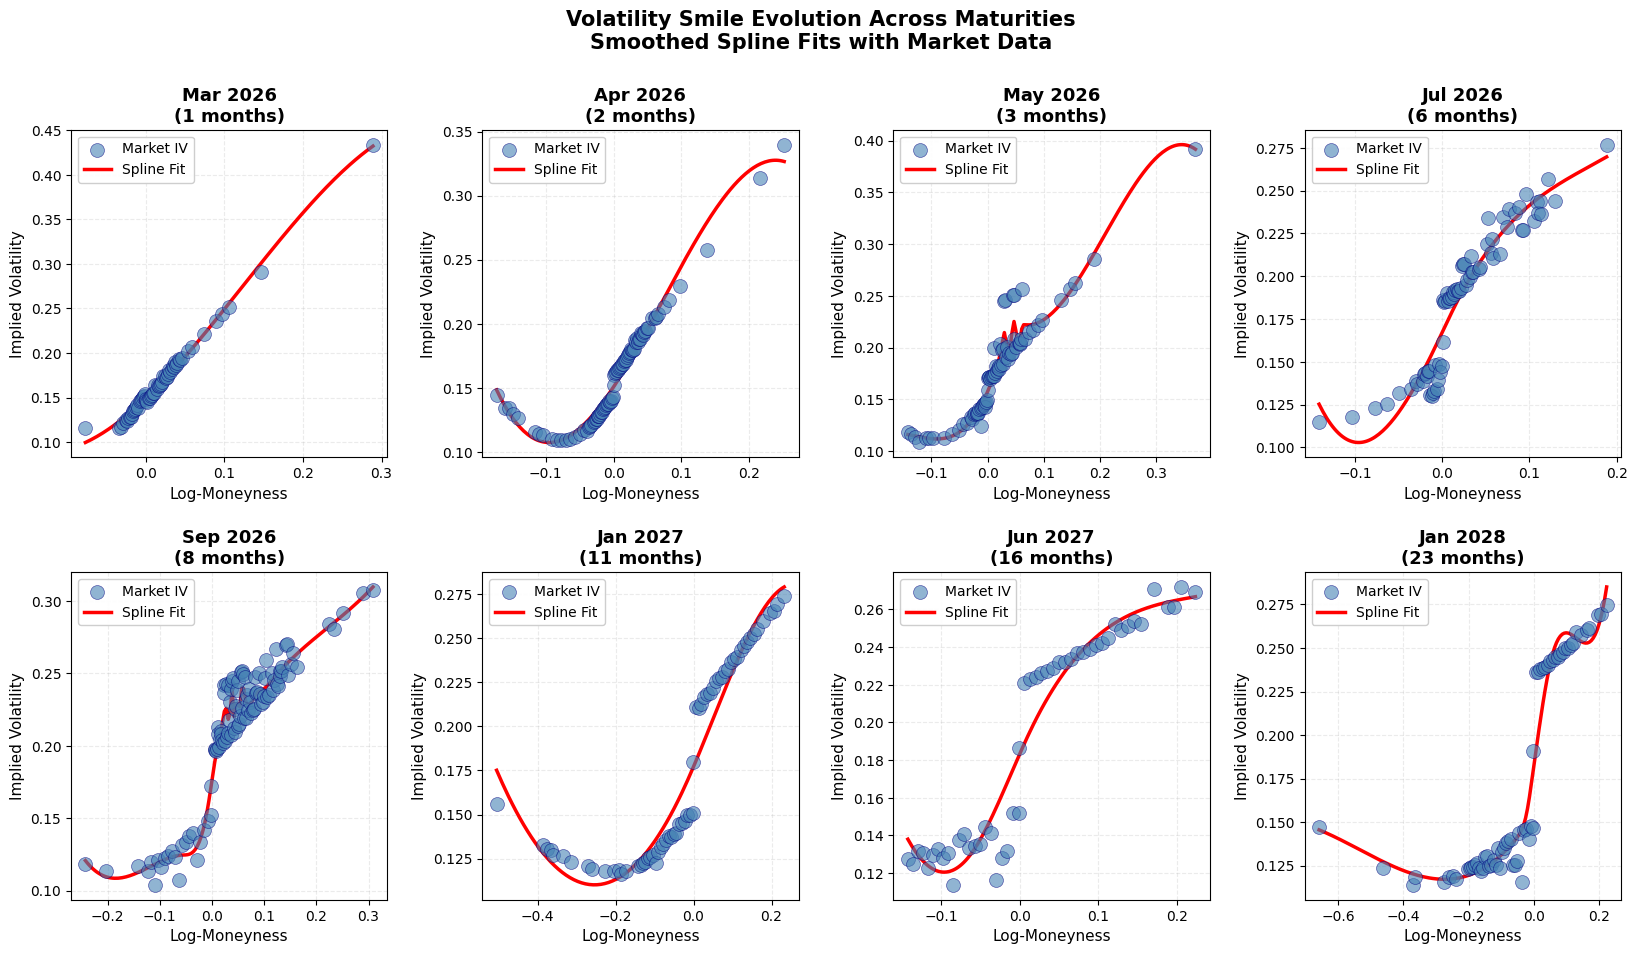

✓ All 8 volatility smiles plotted successfully


In [18]:
# Plot all 8 volatility smiles showing evolution across maturities
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

selected_expirations = sorted(list(spline_fits.keys()))

for idx, exp_date in enumerate(selected_expirations):
    ax = axes[idx]
    
    smile_raw = all_market_smiles[exp_date]
    fit_result = spline_fits[exp_date]
    
    # Sort by log_moneyness for clean plotting
    smile_raw_sorted = smile_raw.sort_values('log_moneyness')
    log_moneyness_raw = smile_raw_sorted['log_moneyness'].values
    iv_raw = smile_raw_sorted['implied_volatility'].values
    
    # Plot raw points (market data)
    ax.scatter(log_moneyness_raw, iv_raw, s=100, alpha=0.6, 
               label='Market IV', color='steelblue', zorder=3, edgecolors='navy', linewidth=0.5)
    
    # Plot spline fit
    log_m_smooth = np.linspace(log_moneyness_raw.min(), log_moneyness_raw.max(), 150)
    iv_smooth = fit_result['iv_func'](log_m_smooth)
    ax.plot(log_m_smooth, iv_smooth, 'r-', linewidth=2.5, 
            label='Spline Fit', zorder=2)
    
    # Format title with month and tenor
    exp_datetime = pd.to_datetime(exp_date)
    month_name = exp_datetime.strftime('%b %Y')  # Shorter: "Mar 2026"
    days_to_exp = (pd.to_datetime(exp_date) - pd.to_datetime('2026-02-09')).days
    months_to_exp = days_to_exp / 30.44
    months_rounded = round(months_to_exp)
    
    ax.set_title(f'{month_name}\n({months_rounded} months)', fontsize=13, fontweight='bold')
    ax.set_xlabel('Log-Moneyness', fontsize=11)
    ax.set_ylabel('Implied Volatility', fontsize=11)
    ax.legend(loc='best', fontsize=10, framealpha=0.95)
    ax.grid(True, alpha=0.25, linestyle='--')
    
    # Adjust tick label size
    ax.tick_params(labelsize=10)

plt.suptitle('Volatility Smile Evolution Across Maturities\nSmoothed Spline Fits with Market Data', 
             fontsize=15, fontweight='bold', y=1.00)
plt.subplots_adjust(hspace=0.35, wspace=0.3)
plt.savefig('smile_fits.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ All 8 volatility smiles plotted successfully")

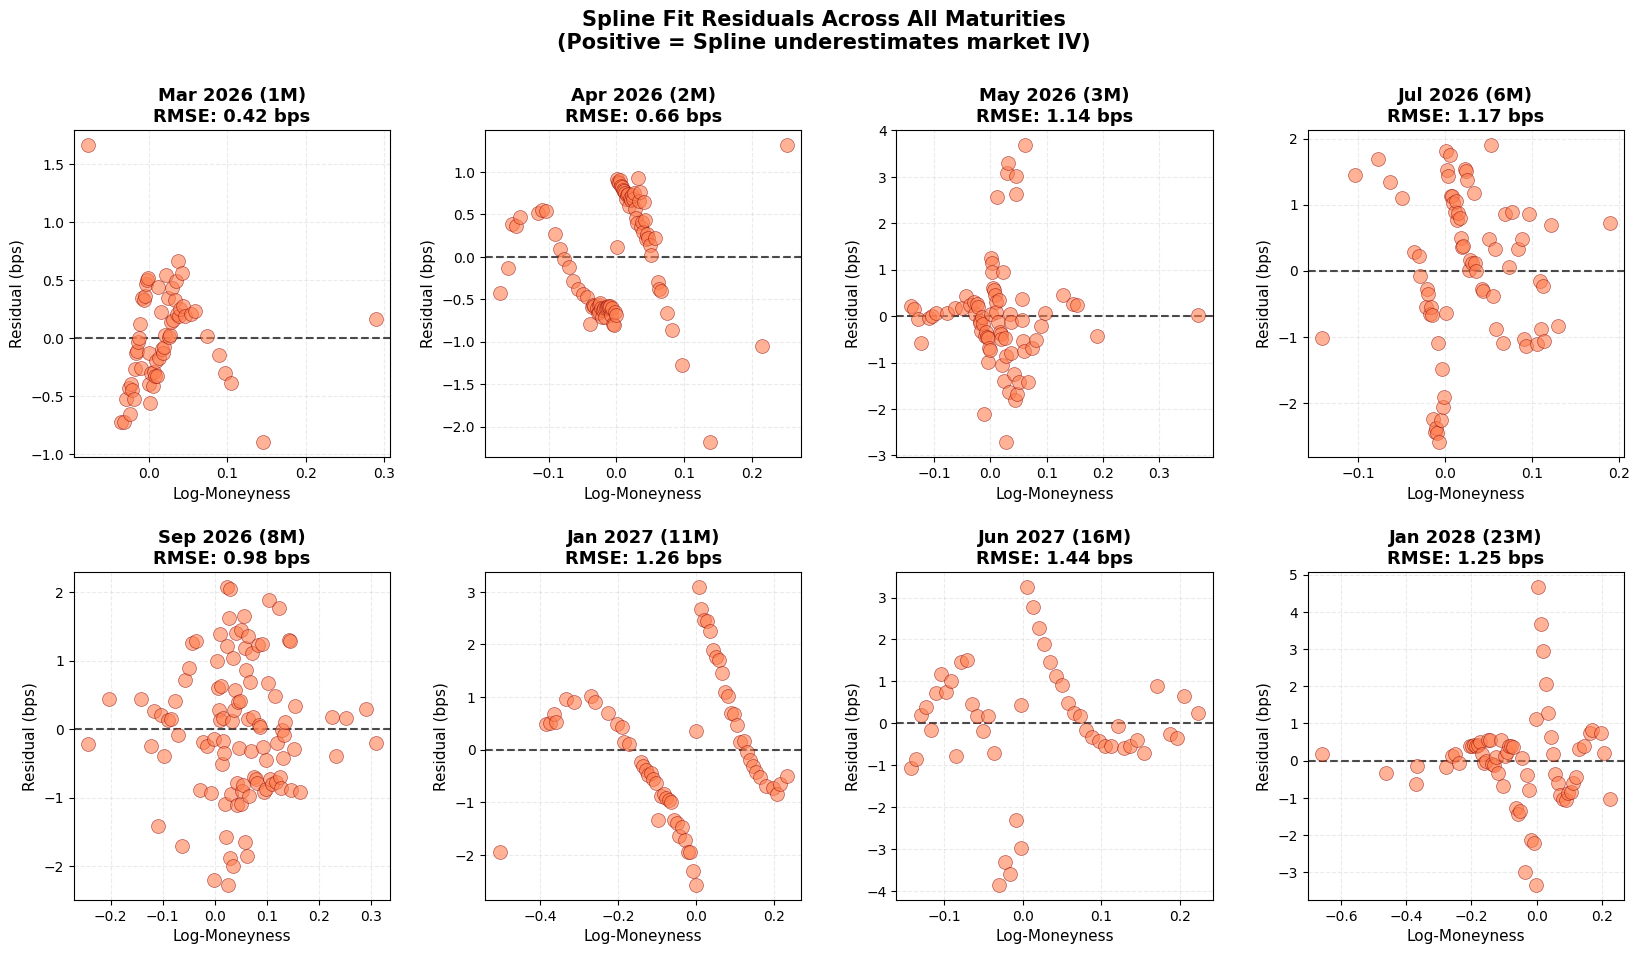


SPLINE FIT RESIDUALS SUMMARY - ALL 8 EXPIRATIONS
    expiry  RMSE (bps)  MAE (bps)  Max Abs (bps)
2026-03-13    0.424563   0.334825       1.665028
2026-04-17    0.664439   0.590253       2.186402
2026-05-15    1.139610   0.748387       3.695379
2026-07-31    1.170452   0.961826       2.599412
2026-09-30    0.976278   0.785389       2.273865
2027-01-15    1.259866   1.021228       3.091918
2027-06-17    1.443325   1.033939       3.857777
2028-01-21    1.249997   0.823711       4.667989


In [19]:
# Analyze and visualize residuals for all expirations
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

residual_stats = []

for idx, exp_date in enumerate(selected_expirations):
    ax = axes[idx]
    
    smile_raw = all_market_smiles[exp_date]
    fit_result = spline_fits[exp_date]
    
    smile_raw_sorted = smile_raw.sort_values('log_moneyness')
    log_moneyness_raw = smile_raw_sorted['log_moneyness'].values
    residuals = fit_result['residuals']
    
    # Residuals plot (in basis points)
    ax.scatter(log_moneyness_raw, residuals * 100, s=100, alpha=0.6,
               color='coral', zorder=3, edgecolors='darkred', linewidth=0.5)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
    
    # Compute stats
    rmse_bps = np.sqrt(np.mean(residuals**2)) * 100
    mae_bps = np.mean(np.abs(residuals)) * 100
    max_residual_bps = np.max(np.abs(residuals)) * 100
    
    residual_stats.append({
        'expiry': exp_date,
        'RMSE (bps)': rmse_bps,
        'MAE (bps)': mae_bps,
        'Max Abs (bps)': max_residual_bps
    })
    
    # Format title
    exp_datetime = pd.to_datetime(exp_date)
    month_name = exp_datetime.strftime('%b %Y')
    days_to_exp = (exp_datetime - pd.to_datetime('2026-02-09')).days
    months_to_exp = days_to_exp / 30.44
    months_rounded = round(months_to_exp)
    
    ax.set_title(f'{month_name} ({months_rounded}M)\nRMSE: {rmse_bps:.2f} bps', 
                 fontsize=13, fontweight='bold')
    ax.set_xlabel('Log-Moneyness', fontsize=11)
    ax.set_ylabel('Residual (bps)', fontsize=11)
    ax.grid(True, alpha=0.25, linestyle='--')
    ax.tick_params(labelsize=10)

plt.suptitle('Spline Fit Residuals Across All Maturities\n(Positive = Spline underestimates market IV)', 
             fontsize=15, fontweight='bold', y=1.00)
plt.subplots_adjust(hspace=0.35, wspace=0.3)
plt.savefig('residuals_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Print residual statistics
residual_df = pd.DataFrame(residual_stats)
print("\n" + "="*70)
print("SPLINE FIT RESIDUALS SUMMARY - ALL 8 EXPIRATIONS")
print("="*70)
print(residual_df.to_string(index=False))
print("="*70)